# Chance constraints

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.0.5"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Production"


## Import modules

In [1]:
import sys
sys.path.append('../../src')

In [2]:

import pandas 
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.components.result import Result 
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario, plot_fit
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from energiapy.aggregation.reduce_scenario import reduce_scenario, Clustermethod
from energiapy.aggregation.ahc import agg_hierarchial_elbow, IncludeAHC, Fit
from energiapy.aggregation.dtw import dynamic_warping, dynamic_warping_matrix, dynamic_warping_path, IncludeDTW
from energiapy.utils.math_utils import min_max, norm_constant
from energiapy.fitting.dist import fit
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
import pyomo.environ as pyo
import scipy
from pyomo.environ import Constraint
from energiapy.utils.scale_utils import scale_list
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.model.constraints.chance import chance_normal



## Data Import

The following data is needed for the model

- solar and wind profiles : energiapy.fetch_nsrdb_data imports data from the NREL NSRDB database
- power demand : ERCOT for Houston; CAISO for San Diego
- Natural Gas prices: Henry Hub Price Index for both


In [3]:
coord_houston = (29.56999969482422, -95.05999755859375)
weather_houston = pandas.read_csv('../data/weather_houston.csv', index_col=0)
weather_houston.index = pandas.to_datetime(weather_houston.index, utc = True)

solar_houston = solar_power_output(data= weather_houston, coord=coord_houston, sam = 'cecmod', module_params= 'Canadian_Solar_Inc__CS5P_220M', 
                                   inverter = 'cecinverter', inverter_params= 'ABB__MICRO_0_25_I_OUTD_US_208__208V_', 
                                   temperature_params= 'open_rack_glass_glass', aoi_model= 'no_loss', ac_model= 'sandia', spectral_model= 'no_loss')

wind_houston = wind_power_output(data= weather_houston, roughness_length= 0.1, turbine_type= 'V100/1800', hub_height= 92, 
                                 wind_speed_model= 'logarithmic', density_model = 'ideal_gas', temperature_model = 'linear_gradient', 
                                 power_output_model = 'power_coefficient_curve', density_correction = True, obstacle_height = 0, 
                                 observation_height = 10)


In [4]:
ercot = pandas.read_csv('../data/ercot.csv', index_col=0)
ercot.index = pandas.to_datetime(ercot.index, utc = True)
ercot.loc['2016-11-06 23:00:00'] = ercot.loc['2016-11-06 22:00:00'] #random missing value

**Get Weather data**

**Demand data for San Diego (CAISO for SDGE region) and Houston (ERCOT for COAST region)**

In [6]:
demand_df = pandas.read_excel('../data/Native_Load_2019.xlsx')[['COAST']]
demand_df = remove_outliers(demand_df)
demand_array = demand_df.to_numpy()



In [7]:
solar_houston = solar_houston[-8760:]
wind_houston = wind_houston[-8760:]
ercot = ercot[-8760:]

In [8]:
data = demand_array
data = min_max(data)
fit_summary = fit(data)


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 10.2737] [loc=0.341 scale=0.214]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 19.3885] [loc=0.000 scale=0.341]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 19.3885] [loc=-67108864.000 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.09 sec] [RSS: 7.52412] [loc=0.311 scale=0.179]
[distfit] >INFO> [t         ] [0.88 sec] [RSS: 10.2736] [loc=0.341 scale=0.214]
[distfit] >INFO> [genextreme] [0.25 sec] [RSS: 1.85686] [loc=0.235 scale=0.153]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 2.23979] [loc=-0.008 scale=0.138]
[distfit] >INFO> [lognorm   ] [0.11 sec] [RSS: 1.81404] [loc=-0.093 scale=0.385]
[distfit] >INFO> [beta      ] [0.29 sec] [RSS: 3.13133] [loc=-0.001 scale=1.718]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 22.464] [loc=0.000 scale=1.000]
[distfit] >INFO> [loggamma  ] [0.13 sec] [RSS: 10.3374] [loc=-61.690 scale=8.498]
[distfit] >INFO> Compute confidence intervals [parame

The best fitting distribution is {'name': 'lognorm', 'score': 1.8140374724450319, 'loc': -0.09318737657114787, 'scale': 0.3850048538041255, 'arg': (0.4957491930759643,), 'params': (0.4957491930759643, -0.09318737657114787, 0.3850048538041255), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000193DFB68E20>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c', 'CII_min_alpha': 0.07715682125258727, 'CII_max_alpha': 0.7769845420880174}


In [9]:
mean = fit_summary.loc['norm']['loc']
sd = fit_summary.loc['norm']['scale']

In [10]:

mu = mean  # mean of the normal distribution
sigma = sd  # standard deviation of the normal distribution


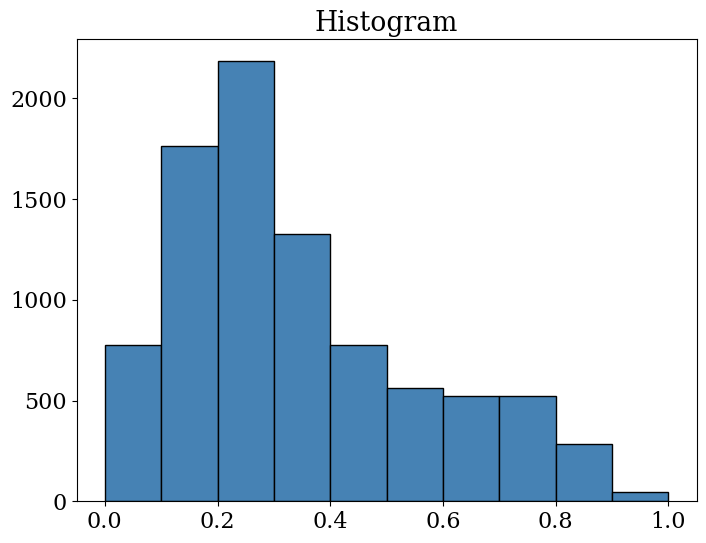

In [11]:
plot_fit.histogram(data = demand_df)

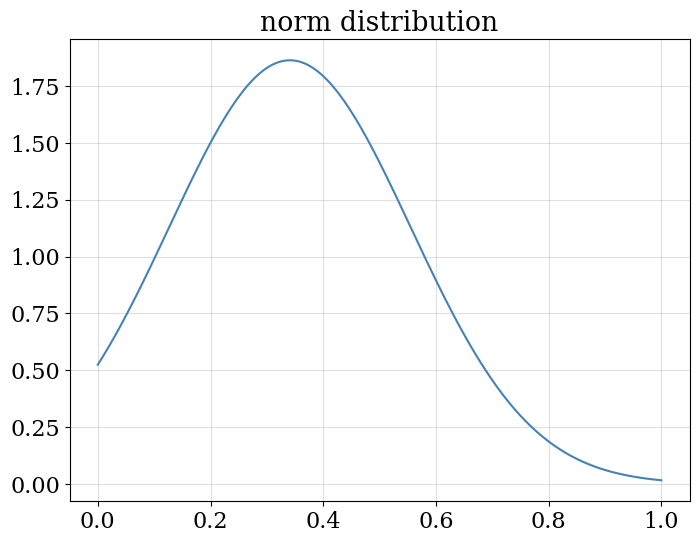

In [12]:
plot_fit.distribution(fit_summary= fit_summary, fit_type= 'norm')

## Define temporal scale


The variabilities of energy systems are best captured over a discretized spatio-temporal scale. In energiapy, the first declaration is the temporal scale. 

For e.g.: Here we declare three temporal scales at different levels from right to left. The interpretation of these scales is merely symentic. Scales can be declared as the problem demands.
- 0, annual, with 1 discretization
- 1, daily with 365 discretization
- 2, hourly with 24 discretization

In essence, we are creating a temporal scale of 8760 points.

In [13]:
scales = TemporalScale(discretization_list=[1, 8760])

In [14]:
bigM = 10**6

In [15]:
compliance_list = [0.1*(i + 1) for i in range(9)] +  [0.95, 0.99]

In [16]:
compliance_list

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 0.95,
 0.99]

## Declare resources

Resources can be consumed, produced, stored, discharged (or sold). 

In [17]:
def model(demand, alpha, compliance_list):
    Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power')

    Wind = Resource(name='Wind', cons_max= bigM, basis='MW', label='Wind Power')

    Power = Resource(name='Power', basis='MW', demand = True, label='Power generated')

    LiI = Process(name='LiI', storage= Power, capex = 1302182, fopex= 41432, vopex = 2000, store_max = 10000, prod_max=bigM, label='Lithium-ion battery', basis = 'MW')

    WF = Process(name='WF', conversion={Wind: -1, Power: 1},capex=990637, fopex=3354, vopex=4953, prod_max=bigM, label='Wind mill array', basis = 'MW')

    PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000, prod_max=bigM, label = 'Solar PV', basis = 'MW')

    houston = Location(name='HO', processes= {WF, PV}, capacity_factor = {PV:solar_houston, WF:wind_houston}, demand_factor = {Power: ercot}, scales=scales, label='Houston', demand_scale_level=1, capacity_scale_level= 1)

    scenario = Scenario(name= 'scenario_full', network= houston, scales= scales,  expenditure_scale_level= 0, scheduling_scale_level= 1, 
                        network_scale_level= 0, demand_scale_level= 1, capacity_scale_level = 1, label= 'full_case', demand = {houston: {Power: 150}})



    lp = formulate(scenario= scenario, 
                        constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE}, 
                        objective=Objective.COST)

    # print(scenario.demand_factor)

    lp.chance_demand = chance_normal(instance = lp, a = 'S', b = demand, b_factor = scenario.demand_factor['HO']['Power'], mean = mu, sd= sigma, compliance_list = compliance_list, alpha = alpha, sign = 'geq')

    return lp, scenario

In [18]:
Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max= bigM, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', demand = True, label='Power generated')

LiI = Process(name='LiI', storage= Power, capex = 1302182, fopex= 41432, vopex = 2000, store_max = 10000, prod_max=bigM, label='Lithium-ion battery', basis = 'MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1},capex=990637, fopex=3354, vopex=4953, prod_max=bigM, label='Wind mill array', basis = 'MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000, prod_max=bigM, label = 'Solar PV', basis = 'MW')

houston = Location(name='HO', processes= {WF, PV}, capacity_factor = {PV:solar_houston, WF:wind_houston}, demand_factor = {Power: ercot}, scales=scales, label='Houston', demand_scale_level=1, capacity_scale_level= 1)

scenario = Scenario(name= 'scenario_full', network= houston, scales= scales,  expenditure_scale_level= 0, scheduling_scale_level= 1, 
                    network_scale_level= 0, demand_scale_level= 1, capacity_scale_level = 1, label= 'full_case', demand = {houston: {Power: 150}})

In [17]:
lps = {i: model(200, i, compliance_list) for i in compliance_list}

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
objective cost
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
objective cost
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
objective cost
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
objective cost
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
objective cost
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint prod

In [18]:
# plot_scenario.demand_factor(scenario = lps[0.9][1], resource= Power, location= list(lps[0.9][1].location_set)[0])

In [19]:
results = {i: solve(scenario = lps[i][1], instance= lps[i][0], solver= 'gurobi', name= 'results', print_solversteps = True) for i in compliance_list}

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 105154 rows, 87635 columns and 236579 nonzeros
Model fingerprint: 0x8ac4d482
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+06]
Presolve removed 78874 rows and 70113 columns
Presolve time: 0.10s
Presolved: 26280 rows, 17522 columns, 52560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 3.504e+04
 Factor NZ  : 1.051e+05 (roughly 20 MB of memory)
 Factor Ops : 4.380e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.16 seconds (0.10 work units)
Barrier solve in

In [20]:
obj = [i.output['objective'] for i in results.values()]

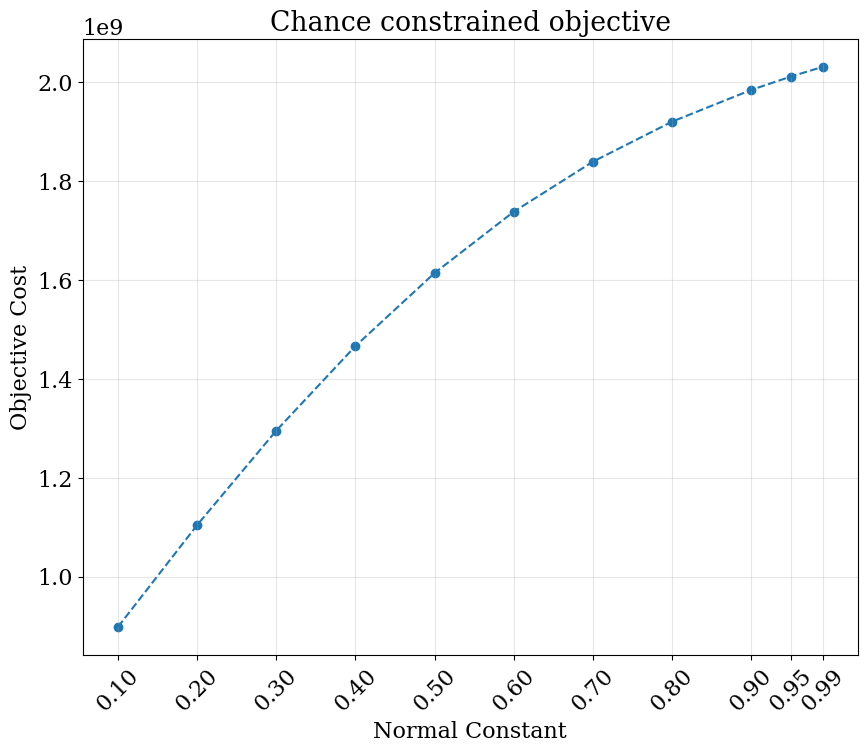

In [21]:
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(10,8))
# ax.plot(x_, y_, linewidth=0.5, color=color)
ax.plot(results.keys(), obj, linestyle = '--')
ax.scatter(results.keys(), obj)

# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Chance constrained objective')
ax.xaxis.set_ticks(list(results.keys()))
# ax.xaxis.set_ticklabels(['1', '1/2', '1/3', '1/4', '1/5', '0'])
plt.ylabel("Objective Cost")
plt.xlabel("Normal Constant")
plt.xticks(rotation = 45)
plt.grid(alpha=0.3)
plt.rcdefaults()

In [22]:
lps[0.9][0].write('chance.lp')

('chance.lp', 2852146817072)

In [23]:
cap_wf = [results[i].output['Cap_P'][('HO', 'WF', 0)] for i in compliance_list]

In [24]:
cap_wf

[33.289216508064214,
 40.92253268446323,
 48.00254286866759,
 54.33673604653772,
 59.813977185532806,
 64.40551500511297,
 68.153764914636,
 71.15359829514522,
 73.53131251023959,
 74.53012706561104,
 75.25382963975338]

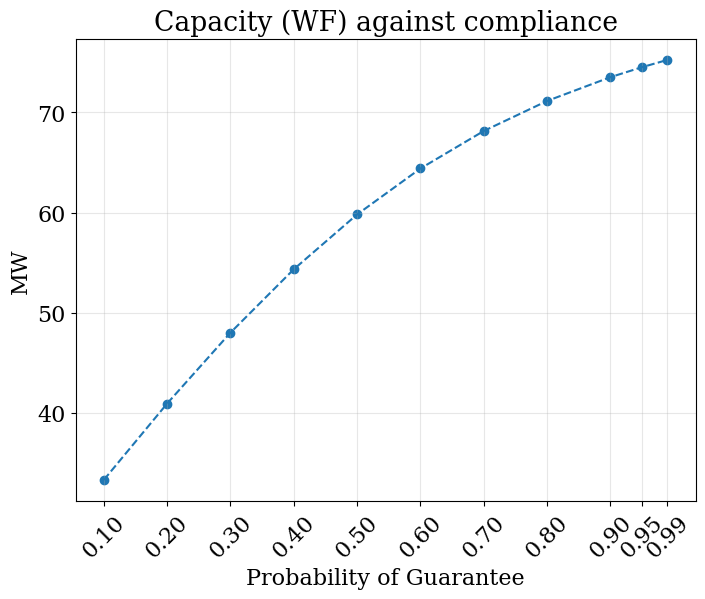

In [25]:
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(x_, y_, linewidth=0.5, color=color)
ax.plot(results.keys(), cap_wf, linestyle = '--')
ax.scatter(results.keys(), cap_wf)

# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Capacity (WF) against compliance')
ax.xaxis.set_ticks(list(results.keys()))
# ax.xaxis.set_ticklabels(['1', '1/2', '1/3', '1/4', '1/5', '0'])
plt.ylabel("MW")
plt.xticks(rotation = 45)
plt.xlabel("Probability of Guarantee")
plt.grid(alpha=0.3)
plt.rcdefaults()

In [26]:
Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max= bigM, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', demand = True, label='Power generated')

$\textbf{Declare processes}$

In [27]:
LiI = Process(name='LiI', storage= Power, capex = 1302182, fopex= 41432, vopex = 2000, store_max = 10000, prod_max=bigM, label='Lithium-ion battery', basis = 'MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1},capex=990637, fopex=3354, vopex=4953, prod_max=bigM, label='Wind mill array', basis = 'MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000, prod_max=bigM, label = 'Solar PV', basis = 'MW')


Processes convert a resource into another through the utilization of resources. 
Essentially, the model is developed as an RTN

In [28]:
houston = Location(name='HO', processes= {WF, PV}, scales=scales, label='Houston', demand_scale_level=1, capacity_scale_level= 0)

scenario = Scenario(name= 'scenario_full', network= houston, scales= scales,  expenditure_scale_level= 0, scheduling_scale_level= 1, 
                    network_scale_level= 0, demand_scale_level= 1, label= 'full_case', demand = {houston: {Power: 150}})


In [29]:
from energiapy.plot import plot_location

In [30]:
# plot_location.demand_factor(resource=Power, location=houston)

**Minimize cost**

In [31]:

lp = formulate(scenario= scenario, 
                      constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE}, 
                      objective=Objective.COST)


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
objective cost


In [32]:
c_dict = {p: norm_constant(p, mu, sigma) for p in [0.80, 0.90, 0.95, 0.99]}

In [33]:
demand_df = min_max(demand_df)
demand_dict = demand_df.to_dict()['COAST']
demand_dict = {(0,i): demand_dict[i] for i in demand_dict.keys()}



In [34]:
def chance_demand(instance, demand_factor, mu, sigma, c_dict, demand, alpha):
    scales = scale_list(instance=instance,
                        scale_levels=2 )
    def chance_rule(instance, location, resource, *scales):
        return instance.S[location, resource, scales] >= demand*demand_factor[scales]*(mu - (1- alpha*c_dict[alpha])*sigma) 
    return Constraint(instance.locations, instance.resources_demand, *scales, rule = chance_rule)
lp.chance_demand = chance_demand(lp, demand_dict, mu, sigma, c_dict, demand =200, alpha = 0.95)

In [35]:
c_dict

{0.8: 1.3370301368543218,
 0.9: 1.250180656708498,
 0.95: 1.2089398223529617,
 0.99: 1.1771687122298473}

In [36]:
alpha = 0.95

In [37]:
mu - (1- alpha*c_dict[alpha])*sigma

0.3726506353280552

In [38]:
c_dict

{0.8: 1.3370301368543218,
 0.9: 1.250180656708498,
 0.95: 1.2089398223529617,
 0.99: 1.1771687122298473}